In [76]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /Users/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
train = pd.read_csv('../writeups.csv', header=0)
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train.head()


There are 147 rows and 4 columns in the training set
There are 147 rows and 4 columns in the training set after removing empty rows


,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"Visiting the website, we are presented with a ...",overview
1,XMarkTheSpot,web,The idea is similar to SQL injection. \nWe hav...,analysis
2,XMarkTheSpot,web,"For example, let's inject:\nThis should tell u...",attack_execution
3,Members,web,"In the challenge members, we need to get more ...",overview
4,Members,web,"If we leave the search query empty, we would s...",analysis


In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Writeup_name  147 non-null    object
 1   Category      147 non-null    object
 2   Text          147 non-null    object
 3   Label         147 non-null    object
dtypes: object(4)
memory usage: 4.7+ KB


In [79]:
train.isnull().sum()

Writeup_name    0
Category        0
Text            0
Label           0
dtype: int64

In [80]:
train = train[train['Text'].notna()]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" columns')

train.head()

There are 147 rows and 4 columns in the training set after removing empty "text" columns


,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"Visiting the website, we are presented with a ...",overview
1,XMarkTheSpot,web,The idea is similar to SQL injection. \nWe hav...,analysis
2,XMarkTheSpot,web,"For example, let's inject:\nThis should tell u...",attack_execution
3,Members,web,"In the challenge members, we need to get more ...",overview
4,Members,web,"If we leave the search query empty, we would s...",analysis


In [81]:
train.isnull().sum()

# train.to_csv(r'train_before_preproc.csv', index=False, header=True)

Writeup_name    0
Category        0
Text            0
Label           0
dtype: int64

# Pre-Processing Steps:

- Expand contractions
- Noise cleaning
- Remove stopwords

In [82]:
# Contraction Mapping

!pip install contractions
import contractions

## Expand Contractions

In [83]:
#train = train[~train['Text'].str.contains("yyyyyyyyyyy")]
#nRow, nCol = train.shape

#print(f'There are {nRow} rows and {nCol} columns in the training set after removing /n')

#train.head()

# train.to_csv(r'train_after_preproc.csv', index=False, header=True)

In [84]:
train['Text'] = train['Text'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])

In [85]:
train.head()

,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"[Visiting, the, website,, we, are, presented, ...",overview
1,XMarkTheSpot,web,"[The, idea, is, similar, to, SQL, injection., ...",analysis
2,XMarkTheSpot,web,"[For, example,, let us, inject:\nThis, should,...",attack_execution
3,Members,web,"[In, the, challenge, members,, we, need, to, g...",overview
4,Members,web,"[If, we, leave, the, search, query, empty,, we...",analysis


In [86]:
#joining back the list of items into one string
train['Text'] = [' '.join(map(str, l)) for l in train['Text']]

In [87]:
train.head()

,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"Visiting the website, we are presented with a ...",overview
1,XMarkTheSpot,web,The idea is similar to SQL injection. \nWe hav...,analysis
2,XMarkTheSpot,web,"For example, let us inject:\nThis should tell ...",attack_execution
3,Members,web,"In the challenge members, we need to get more ...",overview
4,Members,web,"If we leave the search query empty, we would s...",analysis


 ## Noise Cleaning

In [88]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['Text'] = train['Text'].str.lower()
train['Text'] = train['Text'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,visiting the website we are presented with a l...,overview
1,XMarkTheSpot,web,the idea is similar to sql injection \nwe have...,analysis
2,XMarkTheSpot,web,for example let us inject\nthis should tell us...,attack_execution
3,Members,web,in the challenge members we need to get more i...,overview
4,Members,web,if we leave the search query empty we would se...,analysis


In [89]:
#nltk tokenization

train['Text_tokenize'] = train['Text'].apply(word_tokenize)

train.head()

,Writeup_name,Category,Text,Label,Text_tokenize
0,XMarkTheSpot,web,visiting the website we are presented with a l...,overview,"[visiting, the, website, we, are, presented, w..."
1,XMarkTheSpot,web,the idea is similar to sql injection \nwe have...,analysis,"[the, idea, is, similar, to, sql, injection, w..."
2,XMarkTheSpot,web,for example let us inject\nthis should tell us...,attack_execution,"[for, example, let, us, inject, this, should, ..."
3,Members,web,in the challenge members we need to get more i...,overview,"[in, the, challenge, members, we, need, to, ge..."
4,Members,web,if we leave the search query empty we would se...,analysis,"[if, we, leave, the, search, query, empty, we,..."


In [90]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Adding custom stopwords
new_stopwords = ["flag", "challenge", "us"]
stop_words.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stop_words)
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

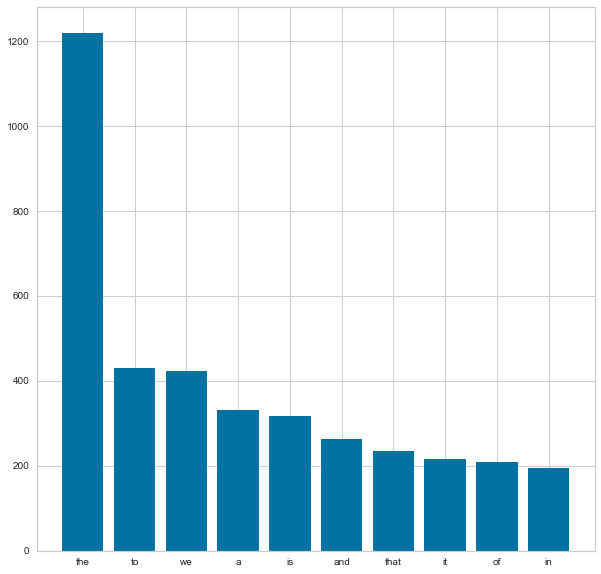

In [92]:
plot_top_stopwords_barchart(train['Text'])

# train.to_csv(r'train_after_noise.csv', index=False, header=True)

In [93]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stop_words)
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

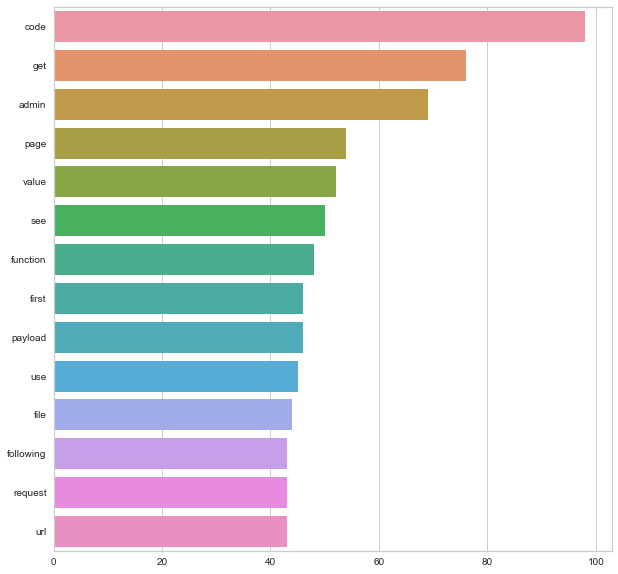

In [94]:
plot_top_non_stopwords_barchart(train['Text'])

## Remove Stopwords

In [95]:
# Now we remove stopwords 

train['Text_tokenize'] = train['Text_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['Text_tokenize_join'] = [' '.join(map(str, l)) for l in train['Text_tokenize']]

train.head()

,Writeup_name,Category,Text,Label,Text_tokenize,Text_tokenize_join
0,XMarkTheSpot,web,visiting the website we are presented with a l...,overview,"[visiting, website, presented, login, form, ro...",visiting website presented login form robert f...
1,XMarkTheSpot,web,the idea is similar to sql injection \nwe have...,analysis,"[idea, similar, sql, injection, vulnerable, qu...",idea similar sql injection vulnerable query au...
2,XMarkTheSpot,web,for example let us inject\nthis should tell us...,attack_execution,"[example, let, inject, tell, password, first, ...",example let inject tell password first usernam...
3,Members,web,in the challenge members we need to get more i...,overview,"[members, need, get, information, members, sou...",members need get information members sounds li...
4,Members,web,if we leave the search query empty we would se...,analysis,"[leave, search, query, empty, would, see, memb...",leave search query empty would see members els...


In [96]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['Text_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

## Yellow Brick: POS Visualizer

In [97]:
# Yellow Brick is a POS visualizer - https://github.com/DistrictDataLabs/yellowbrick/blob/master/docs/api/text/postag.rst
# You may need to reload the workbook to activate it. In that case, re-run all cells again from the beginning 

!pip install -U yellowbrick

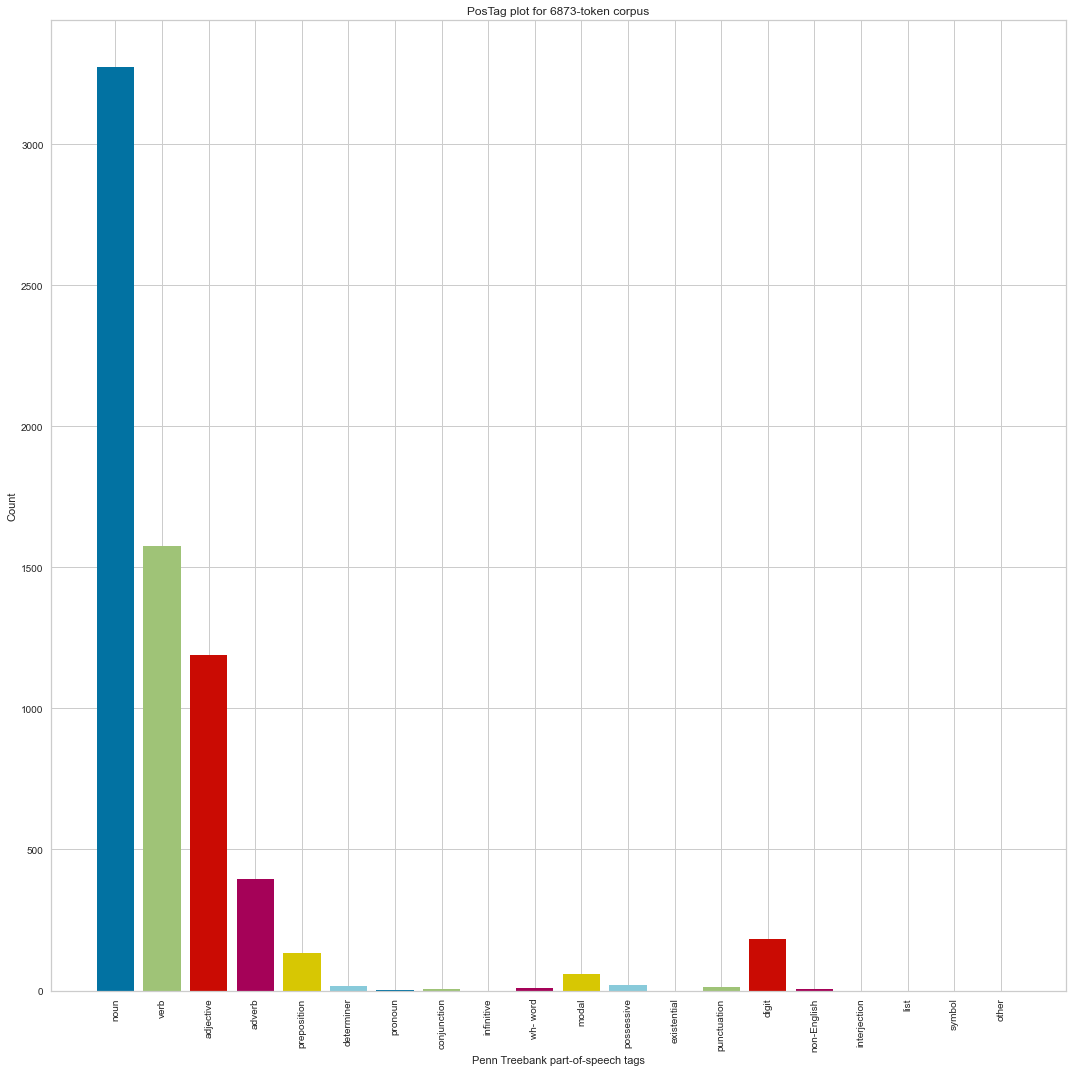

<AxesSubplot:title={'center':'PosTag plot for 6873-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [98]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

# Text Classification Methodology

In [99]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train["Label"].value_counts()

attack_execution    52
analysis            51
overview            44
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

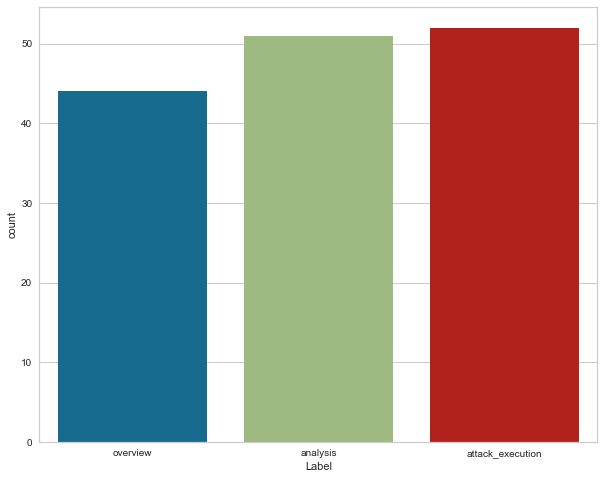

In [100]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["Label"])

In [101]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train['Label'].values

# Drop the 'label' column from train dataset
train.drop("Label", axis=1, inplace = True)
train.head()

,Writeup_name,Category,Text,Text_tokenize,Text_tokenize_join
0,XMarkTheSpot,web,visiting the website we are presented with a l...,"[visiting, website, presented, login, form, ro...",visiting website presented login form robert f...
1,XMarkTheSpot,web,the idea is similar to sql injection \nwe have...,"[idea, similar, sql, injection, vulnerable, qu...",idea similar sql injection vulnerable query au...
2,XMarkTheSpot,web,for example let us inject\nthis should tell us...,"[example, let, inject, tell, password, first, ...",example let inject tell password first usernam...
3,Members,web,in the challenge members we need to get more i...,"[members, need, get, information, members, sou...",members need get information members sounds li...
4,Members,web,if we leave the search query empty we would se...,"[leave, search, query, empty, would, see, memb...",leave search query empty would see members els...


In [102]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [103]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['Text'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)

In [144]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0, test_size=0.25)


In [145]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.73


In [146]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.90
Accuracy of Adaboost classifier on test set: 0.67


In [147]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 0.96
Accuracy of randomforest classifier on test set: 0.60


In [148]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.99
Accuracy of NB classifier on test set: 0.53


In [149]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.67


## Measuring Model Performance

In [150]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.6666666666666666


In [156]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 66.67%


array(['analysis', 'overview', 'overview', 'attack_execution',
       'attack_execution', 'attack_execution', 'overview', 'analysis',
       'analysis', 'attack_execution', 'overview', 'analysis',
       'attack_execution', 'attack_execution', 'attack_execution'],
      dtype=object)

In [152]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[4 0 0]
 [3 4 0]
 [2 0 2]]


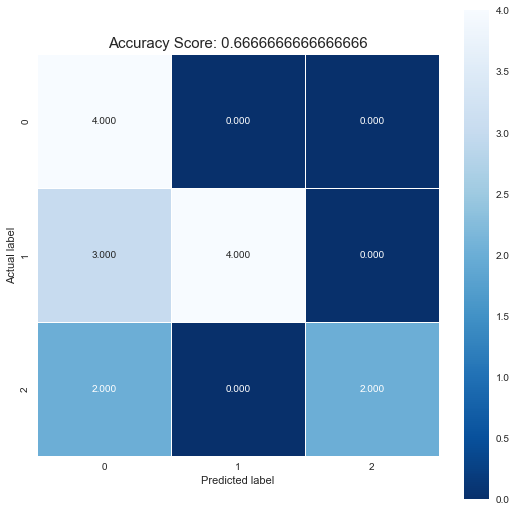

In [153]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### From the confusion matrix we can make the following conclusions:

- Our model successfully predicted 3 positives
- Our model successfully predicted 7 negatives.
- Our model predicted 5 false positives
- Our model predicted 0 false negatives
